In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptop-price1/laptop_price.csv


In [2]:
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor
)

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge
)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [6]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 150)

In [7]:
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/laptop-price1/laptop_price.csv


In [8]:
df = pd.read_csv(
    "/kaggle/input/laptop-price1/laptop_price.csv",
    encoding="ISO-8859-1",
    index_col=0,
)

In [9]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [11]:
display(df.describe())

,Inches,Price_euros
count,1303.000000,1303.000000
mean,15.017191,1123.686992
std,1.426304,699.009043
min,10.100000,174.000000
25%,14.000000,599.000000
50%,15.600000,977.000000
75%,15.600000,1487.880000
max,18.400000,6099.000000


In [12]:
display(df.describe(include=["object"]))

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303
unique,19,618,6,40,118,9,39,110,9,179
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,297,30,727,507,190,619,412,281,1072,121


In [13]:
df["Price_euros"] = pd.to_numeric(df["Price_euros"], errors="coerce")
df = df.dropna(subset=["Price_euros"]).reset_index(drop=True)

In [14]:
categorical_features_raw = df.select_dtypes(include=["object", "category"]).columns
numerical_features_raw = df.select_dtypes(include=["int64", "float64"]).columns


In [15]:
def plot_barplot(data, feature, plot_size=(20, 6)):
    plt.figure(figsize=plot_size)
    sns.countplot(x=data[feature])
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

In [16]:
def plot_histogram(data, feature, bins=30):
    plt.figure(figsize=(10, 6))
    plt.hist(data[feature], bins=bins, edgecolor="k", alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [17]:
def plot_boxplot(data, feature):
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[feature])
    plt.xlabel(feature)
    plt.show()

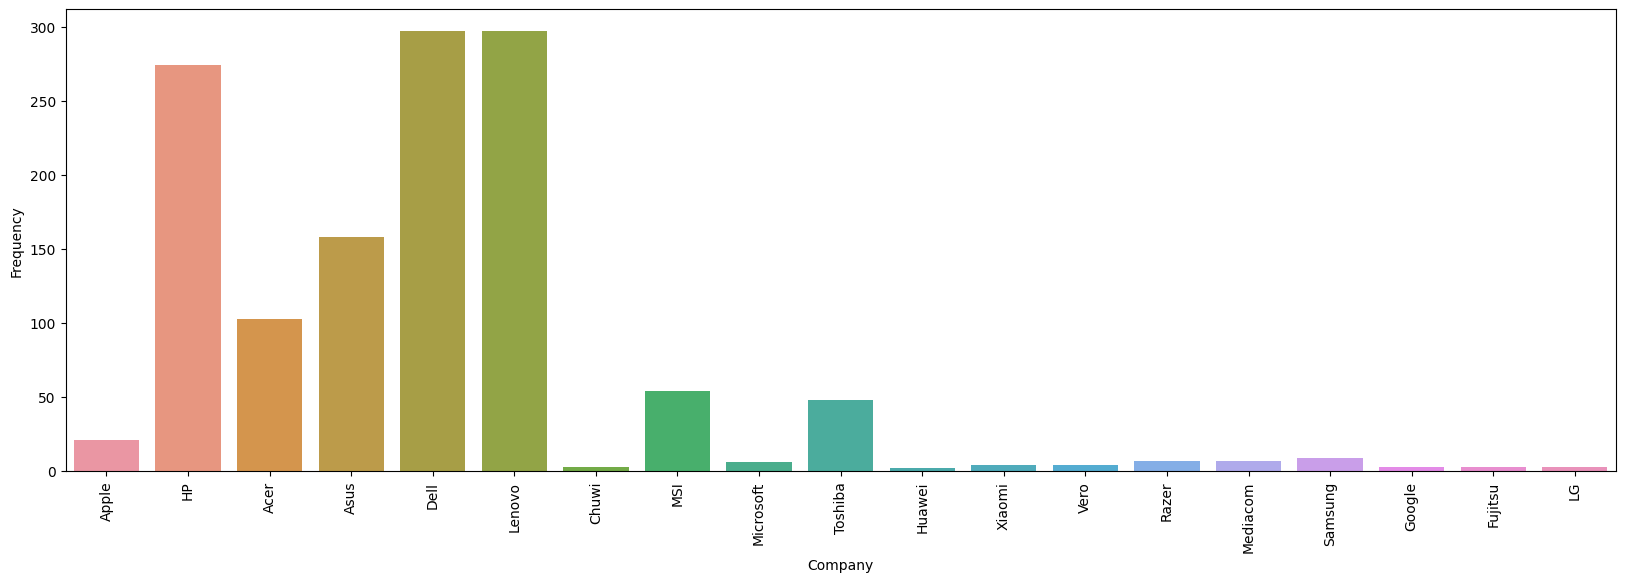

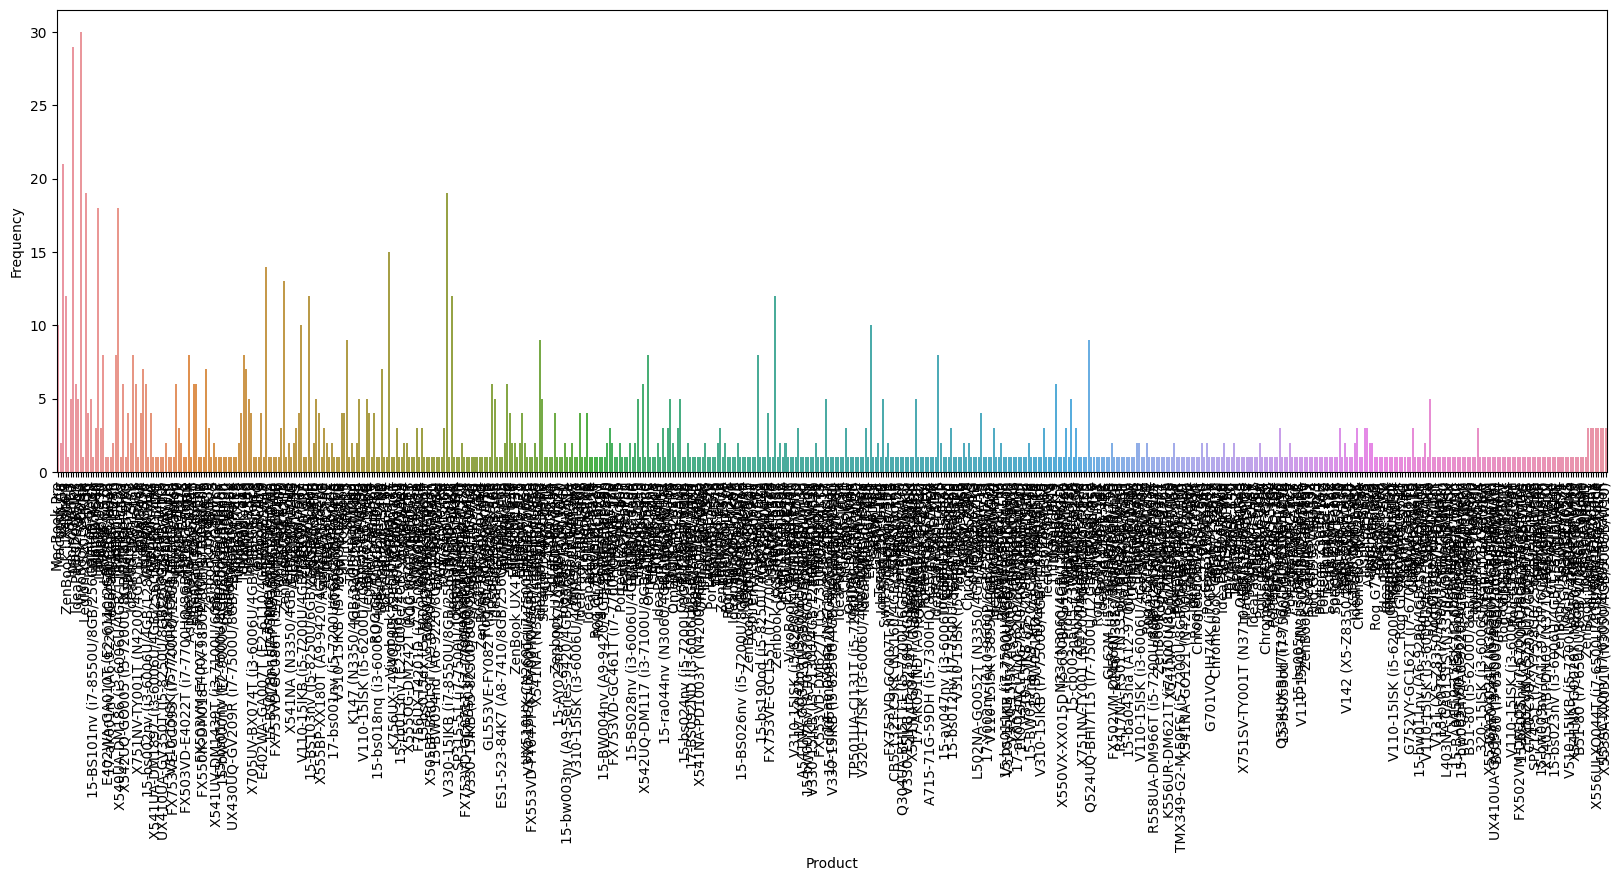

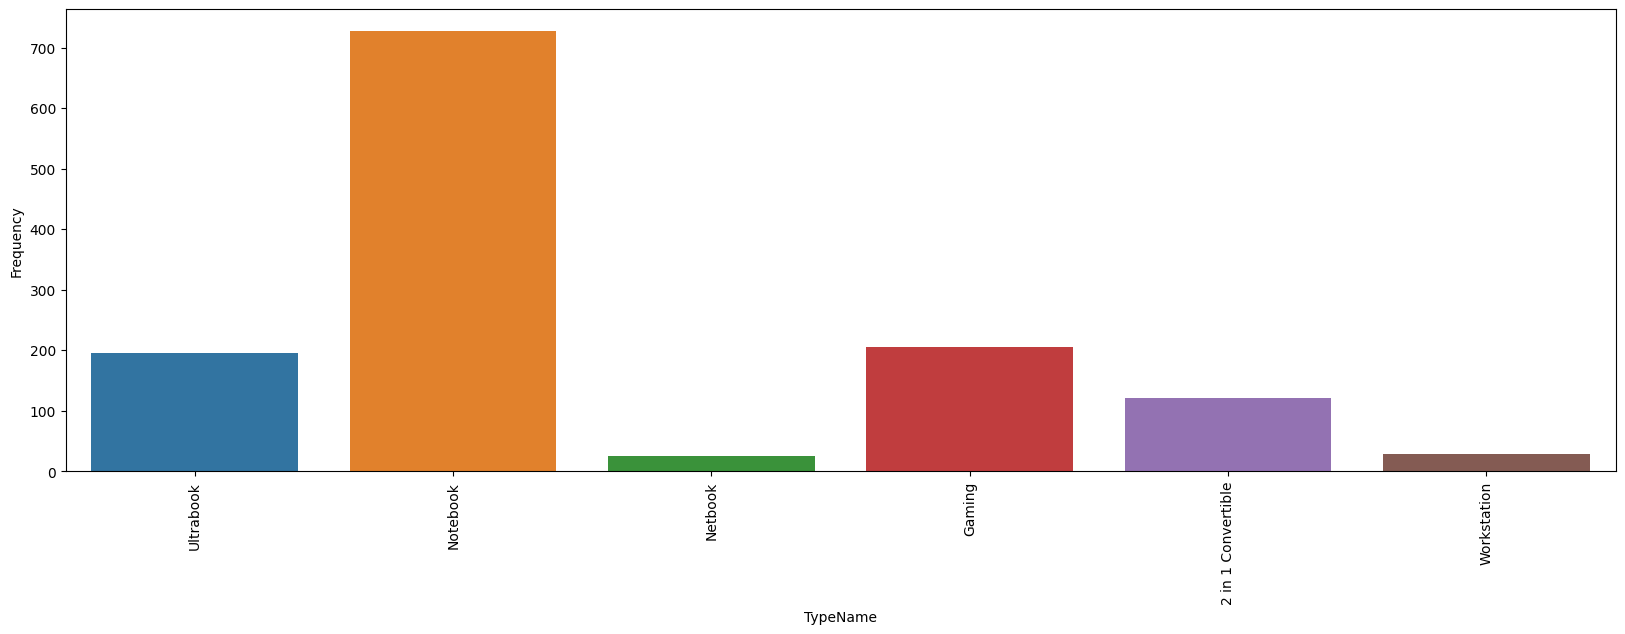

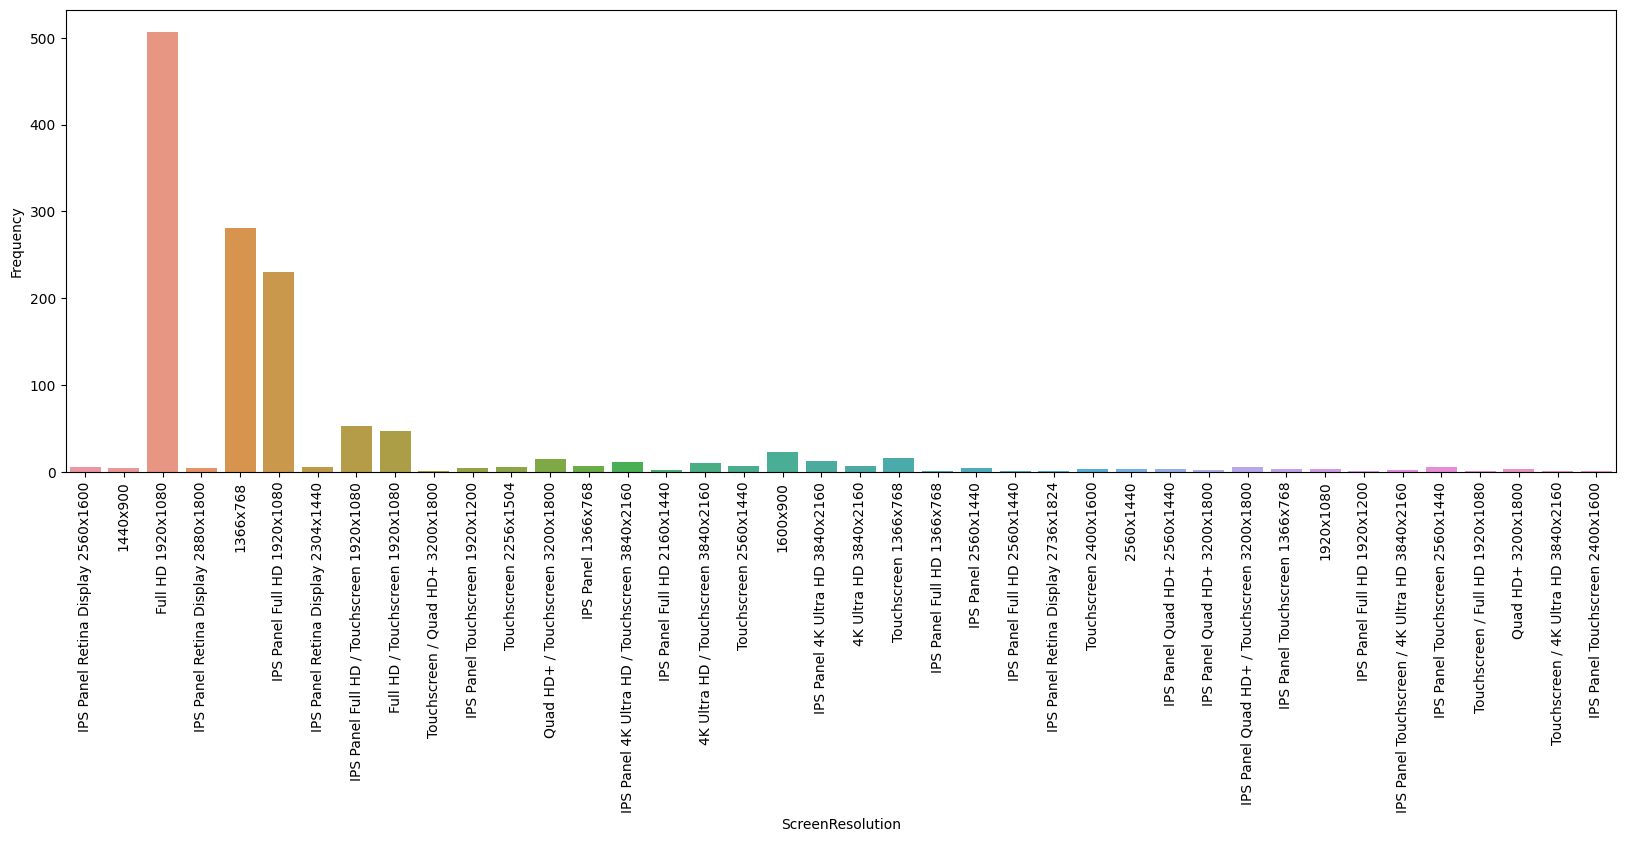

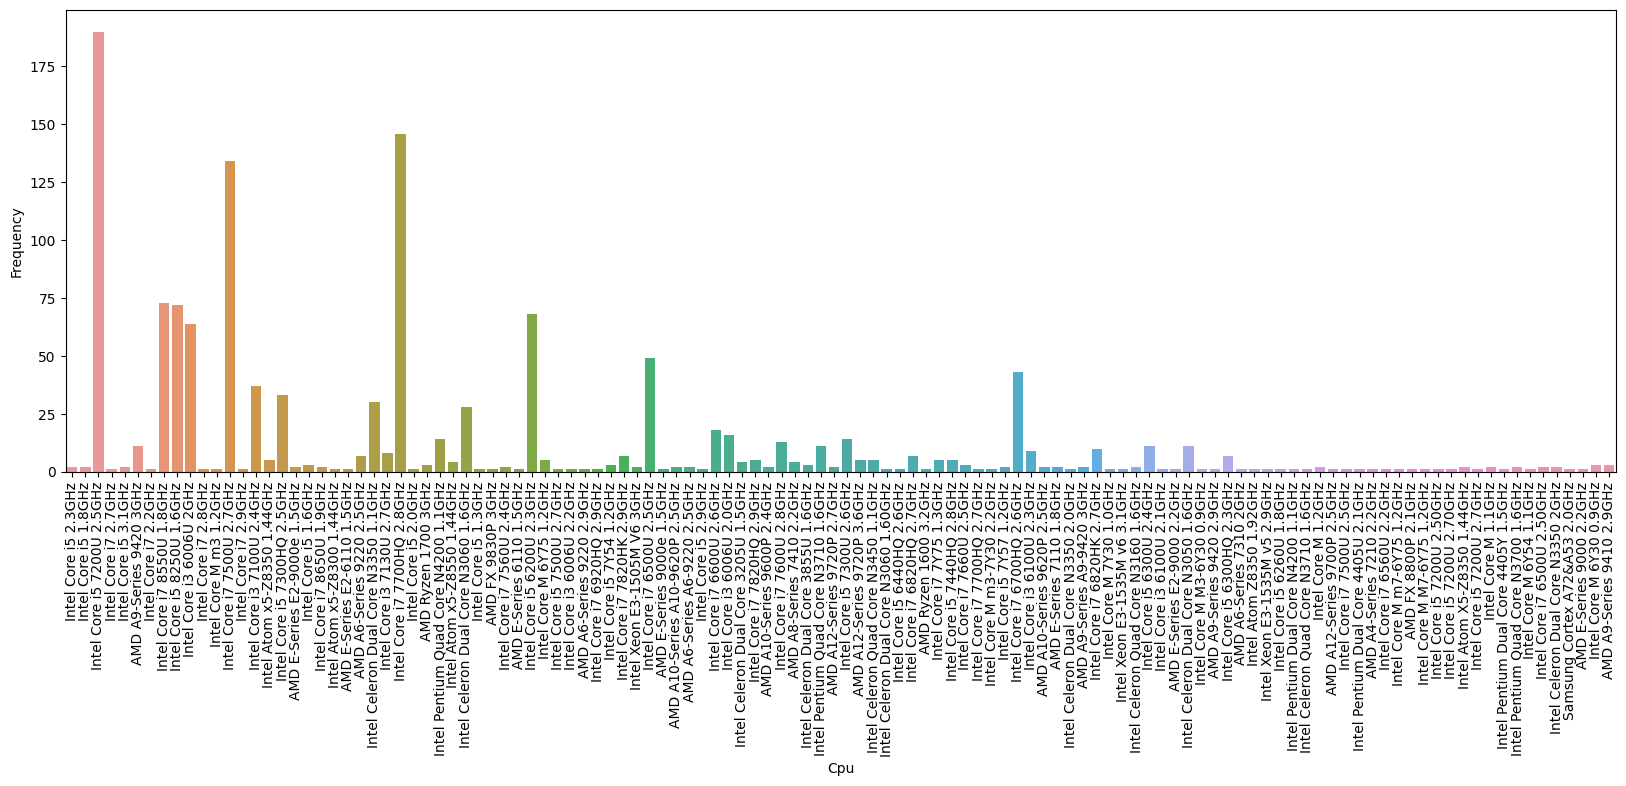

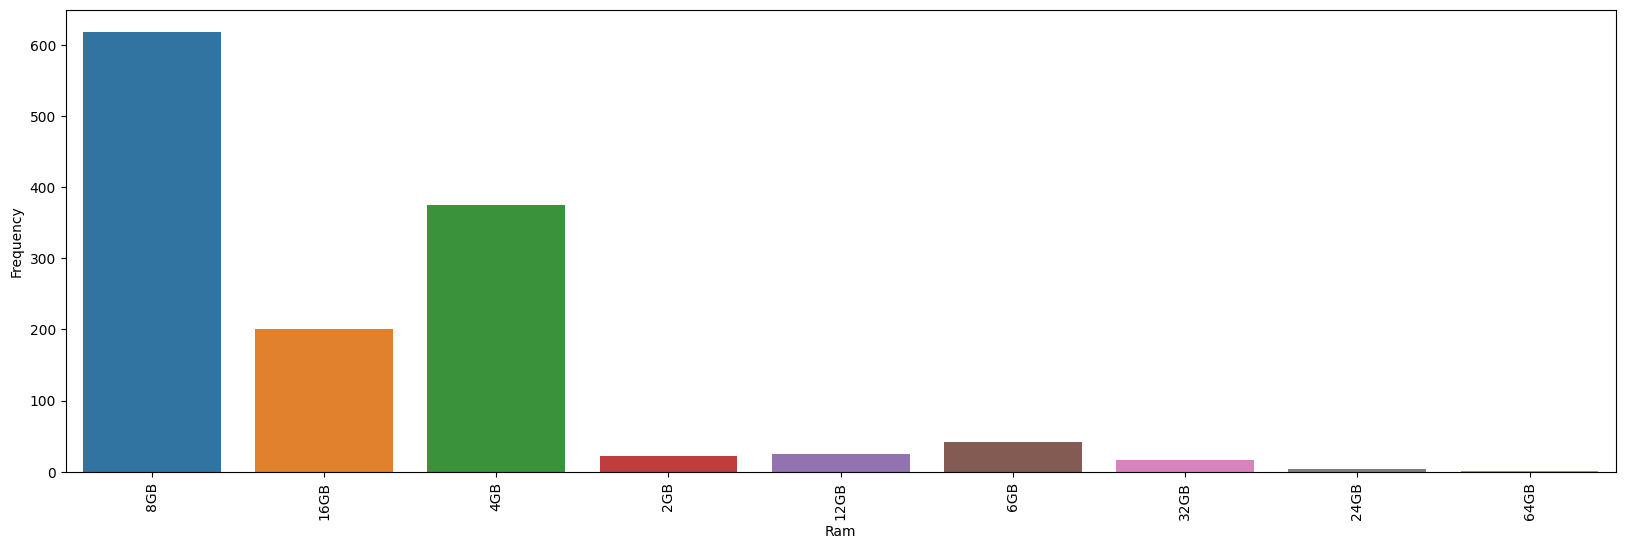

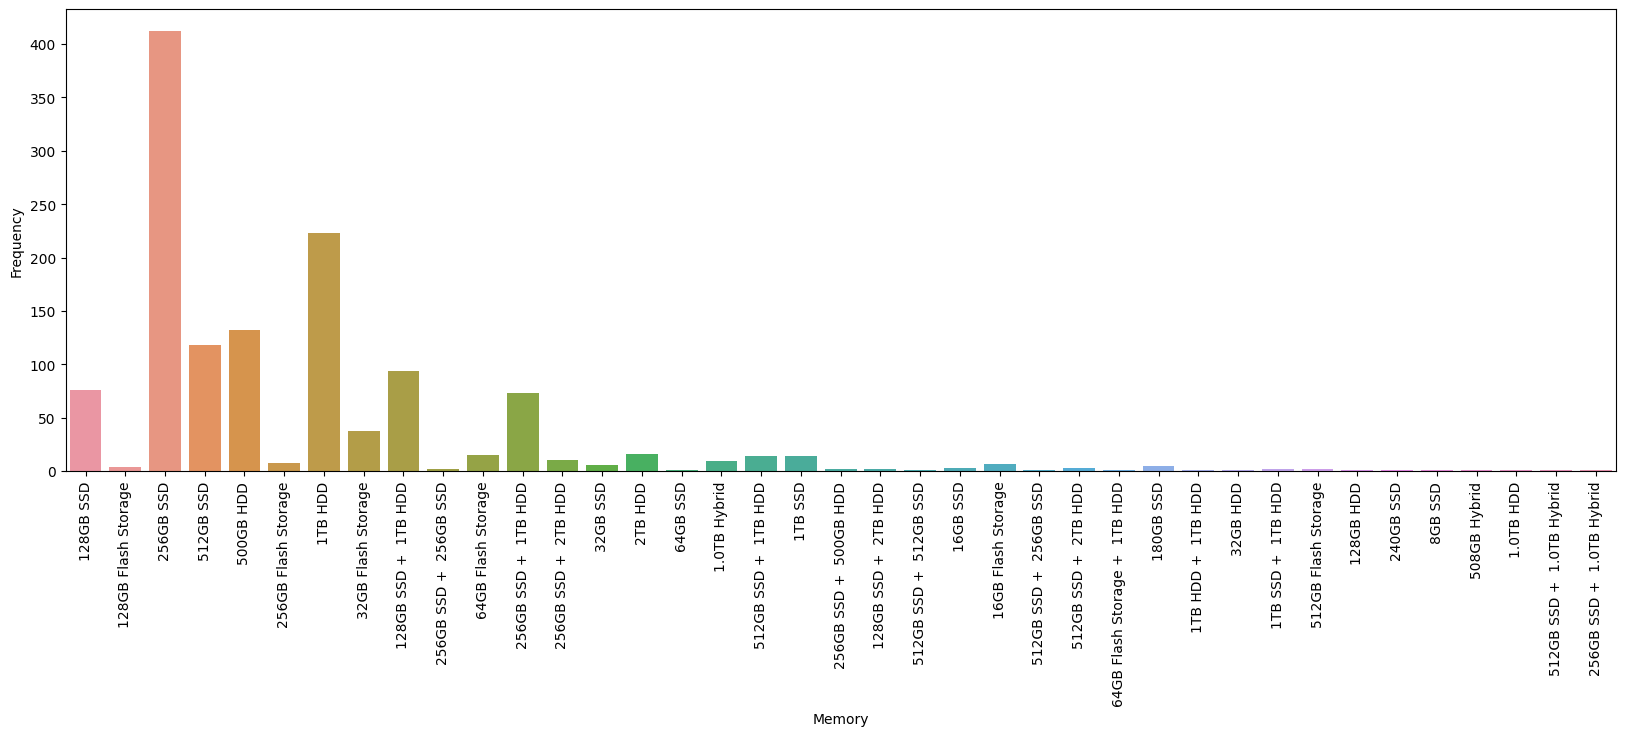

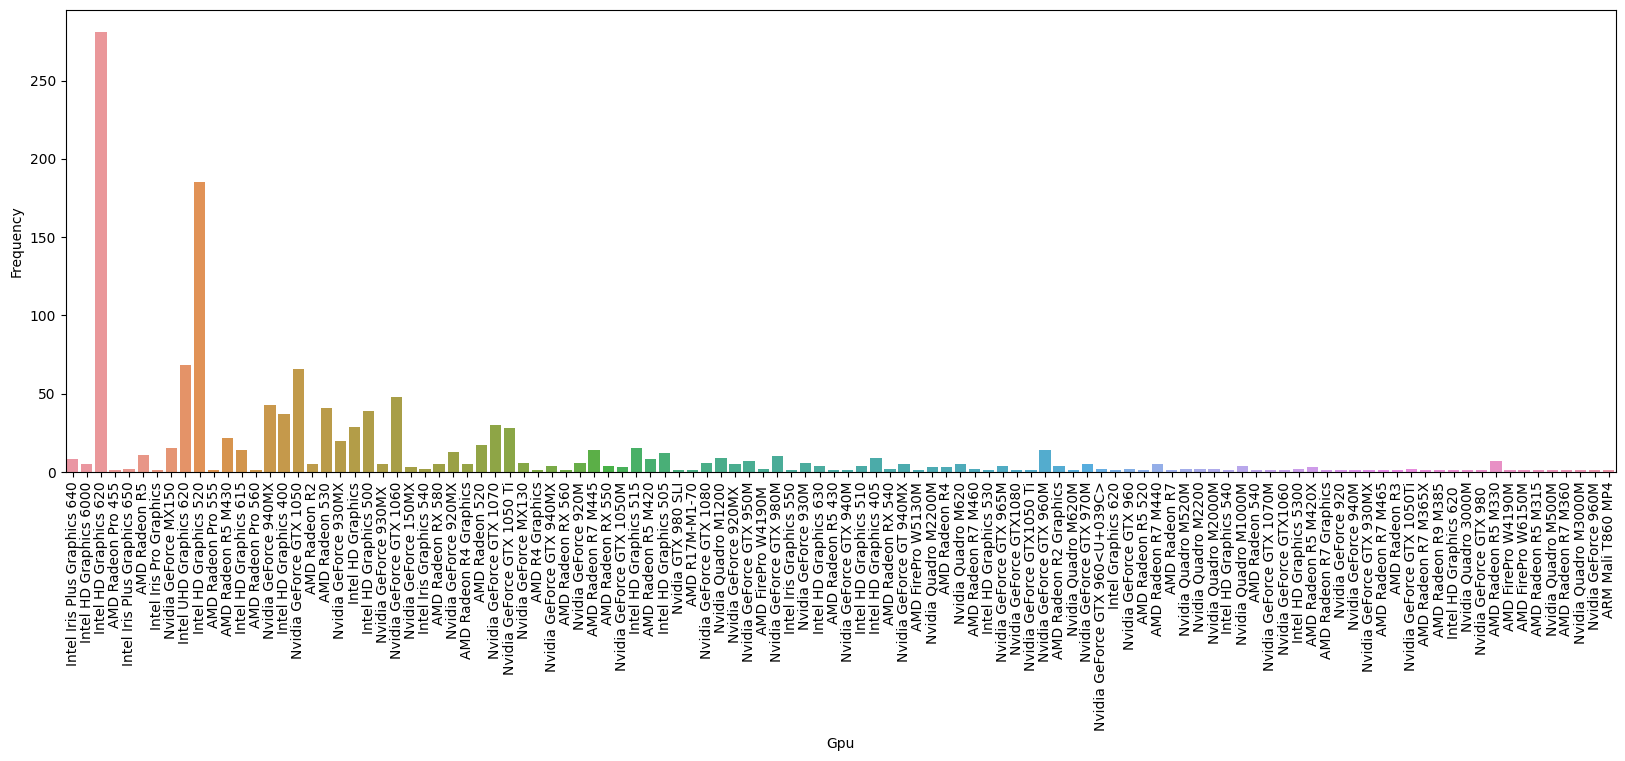

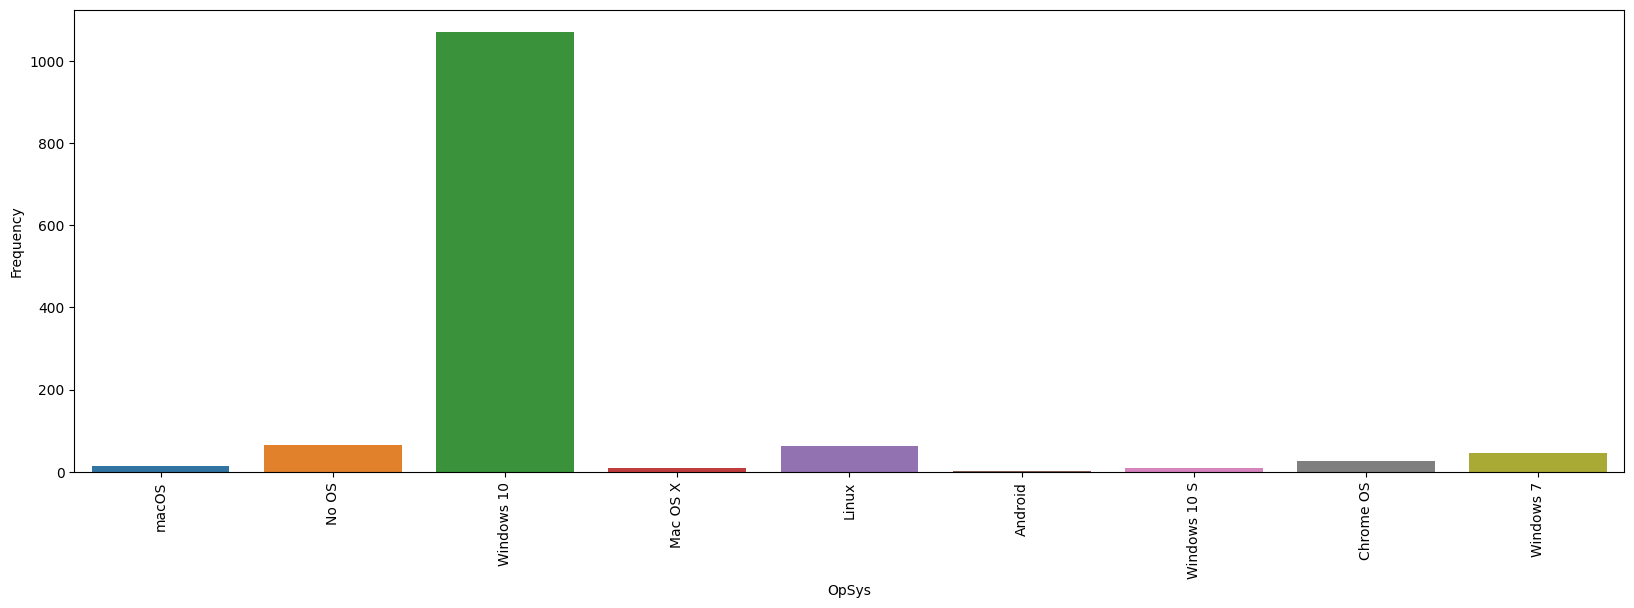

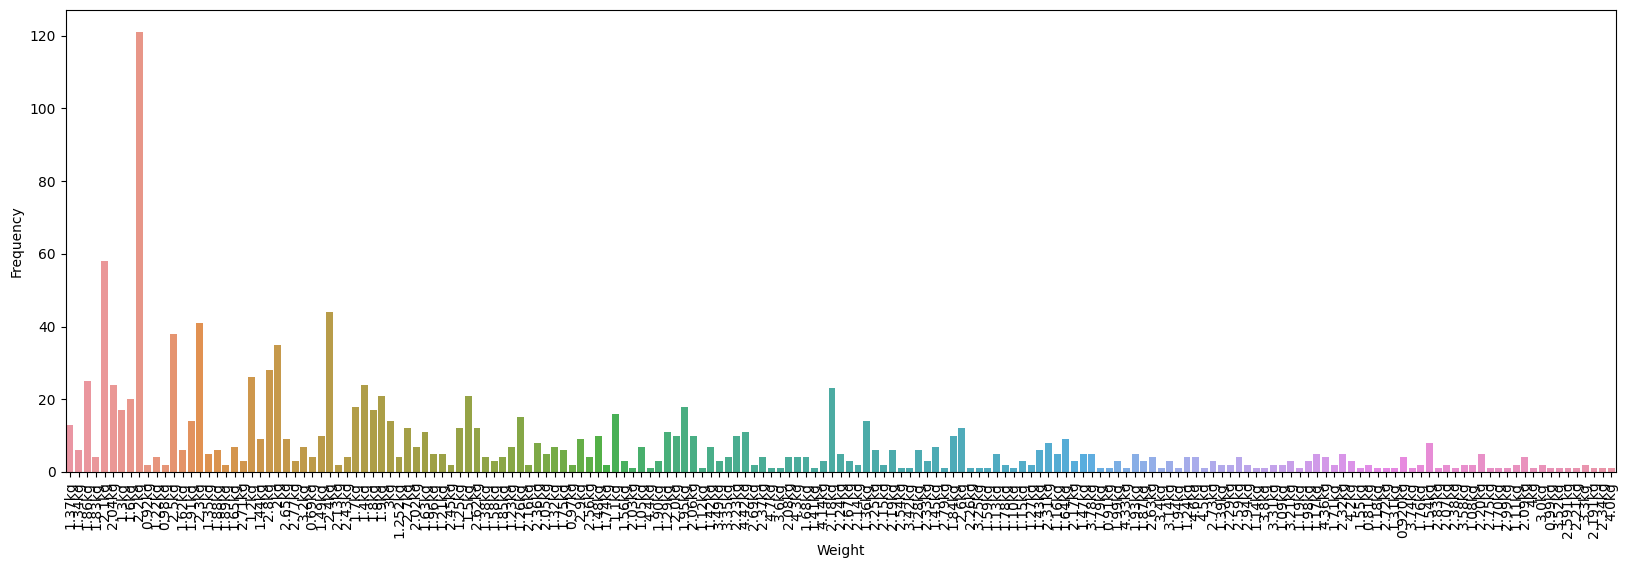

In [18]:
for cat in categorical_features_raw:
    plot_barplot(df, cat)


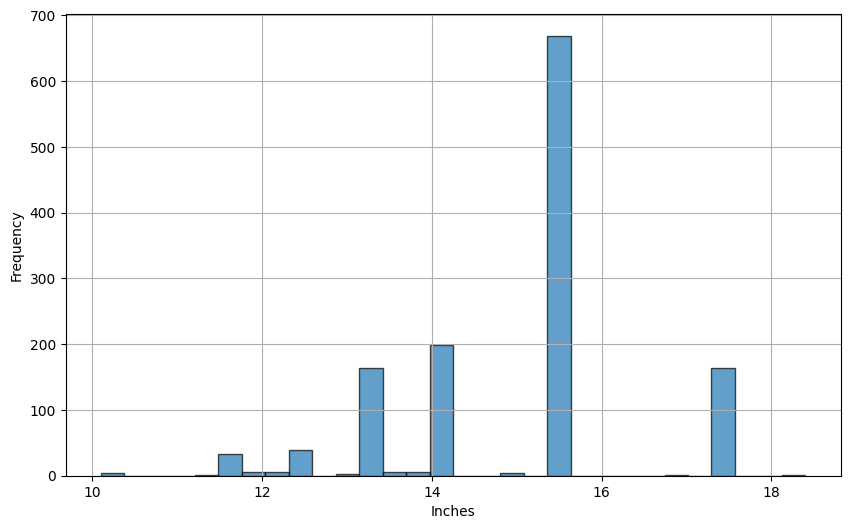

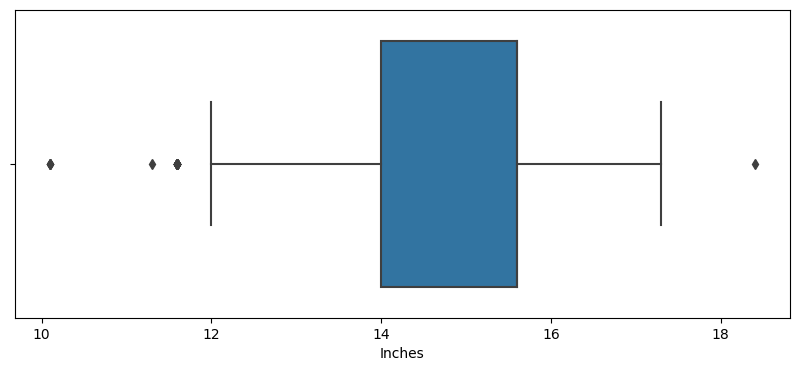

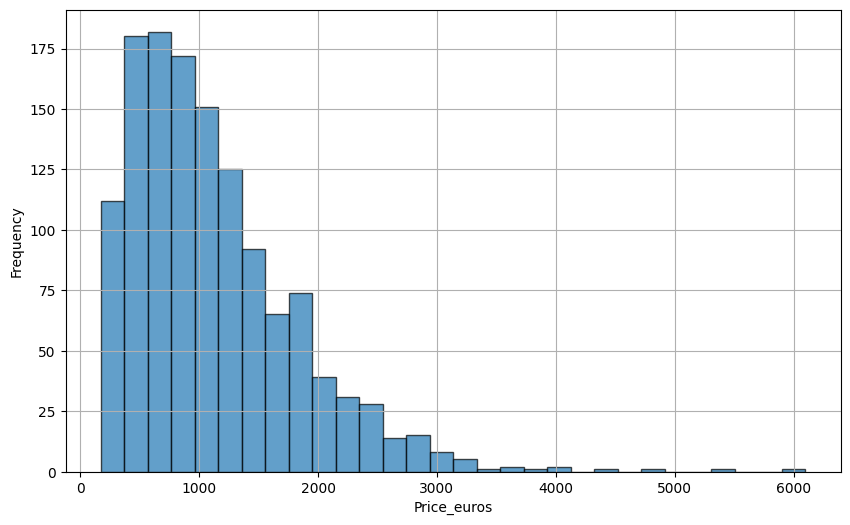

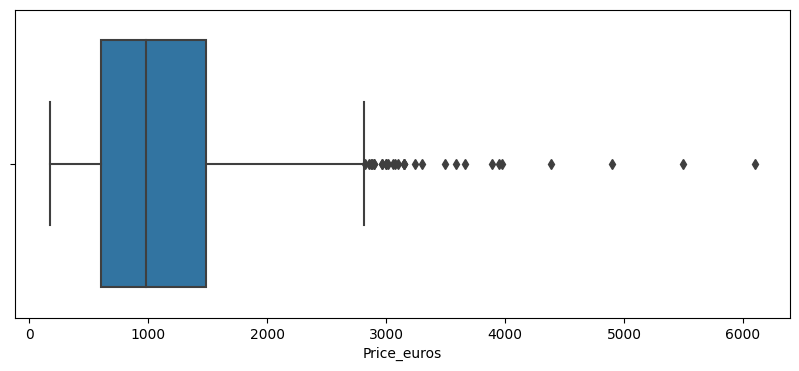

In [19]:
for num in numerical_features_raw:
    plot_histogram(df, num)
    plot_boxplot(df, num)

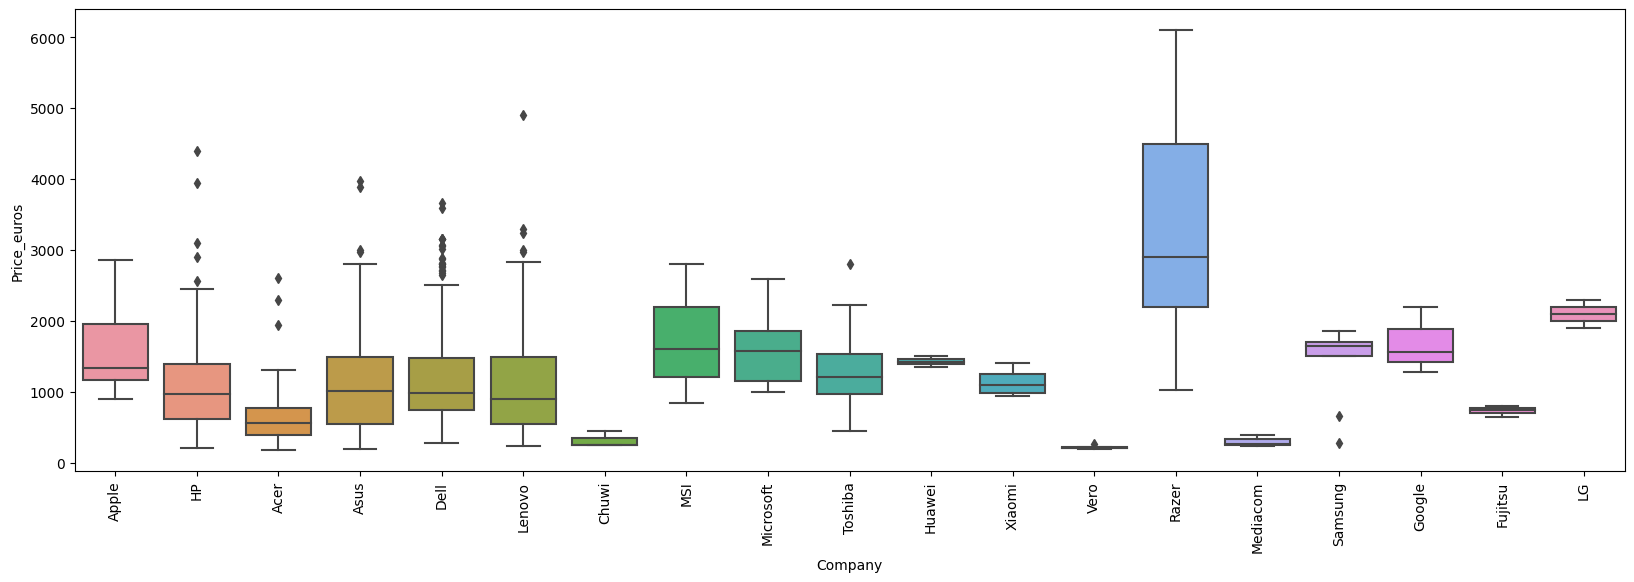

In [20]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x="Company", y="Price_euros")
plt.xticks(rotation=90)
plt.show()

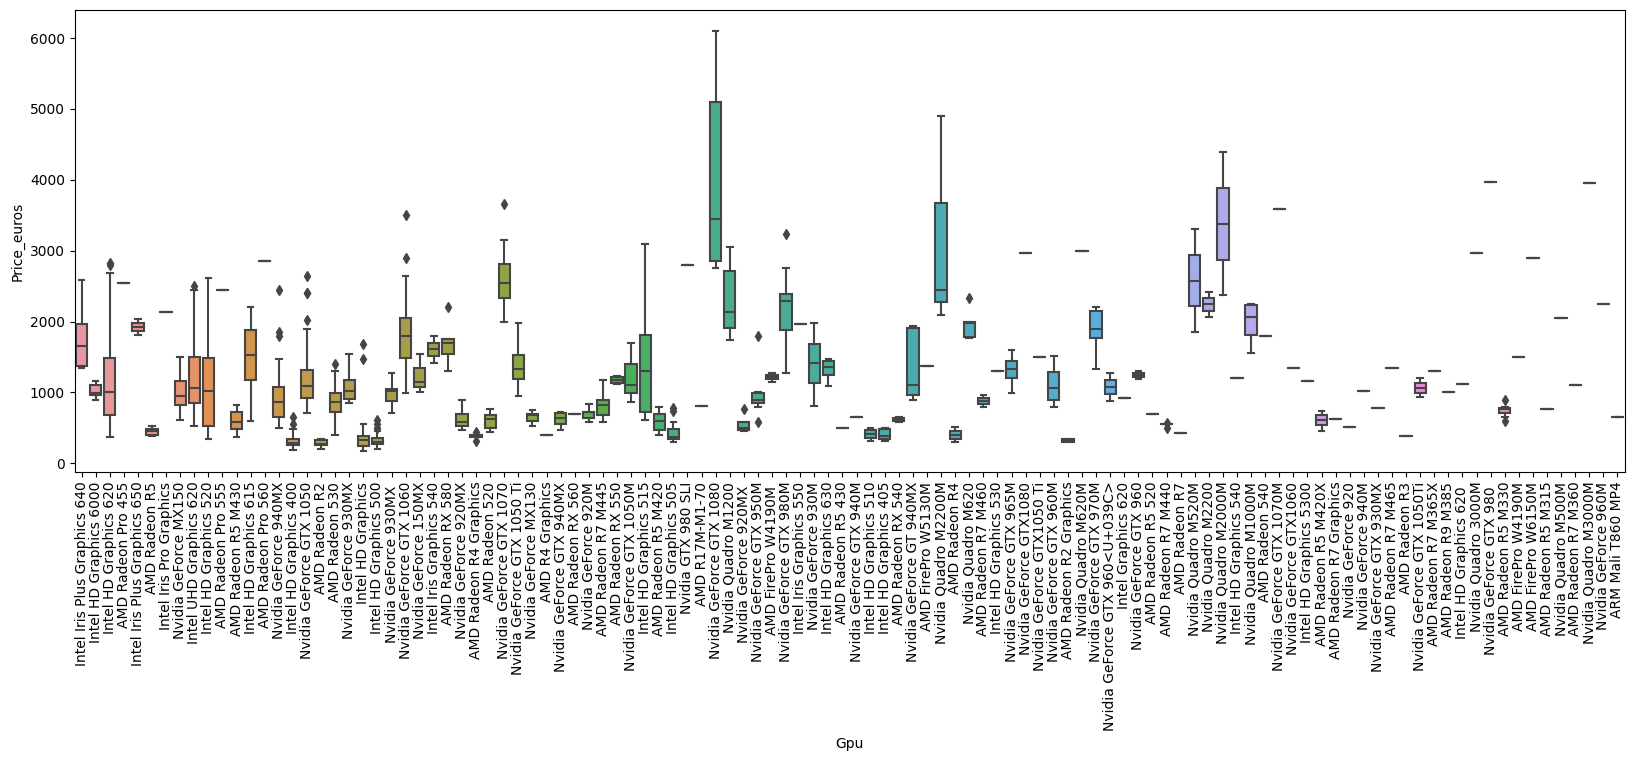

In [21]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x="Gpu", y="Price_euros")
plt.xticks(rotation=90)
plt.show()

In [22]:
df_clean = df.copy()

In [23]:
df_clean["Ram"] = (
    df_clean["Ram"]
    .astype(str)
    .str.replace("GB", "", regex=False)
    .astype("int64")
)

In [24]:
df_clean["Weight"] = (
    df_clean["Weight"]
    .astype(str)
    .str.replace("kg", "", regex=False)
    .astype("float64")
)

In [25]:
#طلع حجم الذاكره من الكولوم بتاعها 

df_clean["Memory_GB"] = (
    df_clean["Memory"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype("int64")
)

In [26]:
df_clean = df_clean.drop(columns=["Memory"])


In [27]:
numeric_features_for_capping = [
    col
    for col in df_clean.select_dtypes(include=["int64", "float64"]).columns
    if col != "Price_euros"
]

In [28]:
for col in numeric_features_for_capping:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])
    df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])


In [29]:
df_clean.describe()

,Inches,Ram,Weight,Price_euros,Memory_GB
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.021719,7.778972,2.013922,1123.686992,226.408289
std,1.411494,3.422204,0.590466,699.009043,174.609551
min,11.600000,2.000000,0.690000,174.000000,1.000000
25%,14.000000,4.000000,1.500000,599.000000,64.000000
50%,15.600000,8.000000,2.040000,977.000000,256.000000
75%,15.600000,8.000000,2.300000,1487.880000,256.000000
max,18.000000,14.000000,3.500000,6099.000000,512.000000


In [30]:
df.describe()

,Inches,Price_euros
count,1303.000000,1303.000000
mean,15.017191,1123.686992
std,1.426304,699.009043
min,10.100000,174.000000
25%,14.000000,599.000000
50%,15.600000,977.000000
75%,15.600000,1487.880000
max,18.400000,6099.000000


In [31]:
y = df_clean["Price_euros"]
X = df_clean.drop("Price_euros", axis=1)


In [32]:
X.dtypes

Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                 float64
Gpu                  object
OpSys                object
Weight              float64
Memory_GB           float64
dtype: object

In [33]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()


In [34]:
numeric_features

['Inches', 'Ram', 'Weight', 'Memory_GB']

In [35]:
categorical_features

['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']

In [36]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

# categorical_transformer = Pipeline(
#     steps=[
#         ("onehot", OneHotEncoder(handle_unknown="ignore")),
#     ]
# )

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [37]:
def model_test(X, y, preprocessor, test_size=0.2, random_state=42):
    """تجربة عدة موديلات وتصنيفهم حسب أفضل R2 و RMSE."""

    models = [
        LinearRegression(),
        Ridge(),
        Lasso(),
        ElasticNet(),
        BayesianRidge(),
        DecisionTreeRegressor(),
        RandomForestRegressor(random_state=random_state),
        ExtraTreesRegressor(random_state=random_state),
        GradientBoostingRegressor(random_state=random_state),
        KNeighborsRegressor(),
        XGBRegressor(
            objective="reg:squarederror",
            random_state=random_state,
            n_estimators=300,
        ),
        LGBMRegressor(random_state=random_state),
        CatBoostRegressor(verbose=0, random_state=random_state),
    ]

    model_names = [
        "Linear Regression",
        "Ridge",
        "Lasso",
        "Elastic Net",
        "Bayesian Ridge",
        "Decision Tree",
        "Random Forest",
        "Extra Trees",
        "Gradient Boosting",
        "K-Nearest Neighbors",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ]

    r2_scores = []
    rmse_scores = []

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    for name, model in zip(model_names, models):
        pipe = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", model),
            ]
        )

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        r2 = r2_score(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5

        r2_scores.append(np.round(r2 * 100, 2))
        rmse_scores.append(np.round(rmse, 2))

        print(f"{name:25s}  R2: {r2:.3f}   RMSE: {rmse:.2f}")

    results = pd.DataFrame(
        {
            "Model": model_names,
            "R2 Score": r2_scores,
            "RMSE": rmse_scores,
        }
    )

    results = results.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)
    return results


In [38]:
results = model_test(X, y, preprocessor)
display(results)

Linear Regression          R2: -38069642047544852480.000   RMSE: 4397337942931.25
Ridge                      R2: 0.836   RMSE: 288.77
Lasso                      R2: 0.786   RMSE: 329.82
Elastic Net                R2: 0.496   RMSE: 505.92
Bayesian Ridge             R2: 0.842   RMSE: 283.61
Decision Tree              R2: 0.769   RMSE: 342.35
Random Forest              R2: 0.832   RMSE: 292.47
Extra Trees                R2: 0.805   RMSE: 314.48
Gradient Boosting          R2: 0.811   RMSE: 309.76
K-Nearest Neighbors        R2: 0.745   RMSE: 359.75
XGBoost                    R2: 0.839   RMSE: 286.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 54
[LightGBM] [Info] Start training from score 112

,Model,R2 Score,RMSE
0,Bayesian Ridge,8.416000e+01,2.836100e+02
1,XGBoost,8.390000e+01,2.860100e+02
2,Ridge,8.358000e+01,2.887700e+02
3,CatBoost,8.357000e+01,2.888800e+02
4,Random Forest,8.316000e+01,2.924700e+02
5,Gradient Boosting,8.111000e+01,3.097600e+02
6,Extra Trees,8.053000e+01,3.144800e+02
7,Lasso,7.858000e+01,3.298200e+02
8,Decision Tree,7.692000e+01,3.423500e+02
9,K-Nearest Neighbors,7.452000e+01,3.597500e+02
